In [1]:
!pip install git+https://github.com/qubvel/efficientnet
!pip install git+https://github.com/qubvel/classification_models.git
!pip install git+https://github.com/qubvel/segmentation_models
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-znjwg3b0
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-znjwg3b0
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.4 MB/s eta 0:00:00
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18428 sha256=0a14e468f0834d991eb8e17dfda81fb245011da493a9efad84e2fd4550e850df
  Stored in directory: /tmp/pip-ephem-wheel-cache-u4xs2d2t/wheels/bb/0f/38/154505705a0899276d49f521ee621a61bc2a8767026220f751
Successfully built efficientnet
  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-2bvvbm0k
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-2bvvbm0k
  Resolved https://github.co

In [2]:
import os, sys, cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            OneOf, RandomBrightness,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, Resize)
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import albumentations as albu
os.environ["SM_FRAMEWORK"] = "tf.keras"

from segmentation_models import Unet
from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score


Segmentation Models: using `tf.keras` framework.


In [3]:
# make your data generator class
# make a function which splits data into train, test, val to give three generators

In [4]:
class SegBatchDataGenerator(Sequence):
    def __init__(self, img_fname_list, root_dir, img_dir="img", mask_dir="label",
                 gen_type = "train", batch_size=1, img_size = 256,
                 num_channels_in_mask=1, shuffle_every_epoch=True):
        self.img_fname_list = img_fname_list
        self.mask_fname_list = [self.imname_to_maskname(im_name) for im_name in self.img_fname_list]
        print(f"For {gen_type}, number of images = {len(self.img_fname_list)}, number of masks = {len(self.mask_fname_list)}")

        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.root_dir = root_dir
        self.gen_type = gen_type

        self.batch_size = batch_size
        self.img_size = img_size
        self.num_channels_in_mask = num_channels_in_mask
        self.shuffle_every_epoch = shuffle_every_epoch

        # sanity check to see if img and mask match
        if(self.img_mask_sanity()):
            print("All img-mask pairs exist")

        self.batch_index = 0

    def img_mask_sanity(self):
        mask_exists = [((im_name.split(".")[0] + ".png") in self.mask_fname_list) for im_name in self.img_fname_list]
        all_masks_exist = all(mask_exists)
        return all_masks_exist

    def __len__(self):
        return int(np.ceil(len(self.img_fname_list)/self.batch_size))

    def read_image_mask(self, image_name, mask_name):
        im_path = os.path.join(self.root_dir, f"{self.img_dir}/{image_name}")
        mask_path = os.path.join(self.root_dir, f"{self.mask_dir}/{mask_name}")
        mask_arr = ((imread(mask_path, as_gray=True))>0).astype(np.float32)
        # print(f"Mask arr stats : min={np.min(mask_arr)}, max={np.max(mask_arr)}, dtype={mask_arr.dtype}")
        return (imread(im_path)/255).astype(np.float32), (imread(mask_path, as_gray=True) > 0).astype(np.float32)

    def imname_to_maskname(self, image_name):
        return image_name.split(".")[0] + ".png"

    def get_aug_composition(self):
        composition = Compose([
            RandomCrop(width = self.img_size, height = self.img_size, p=1),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            RandomRotate90(p=0.5),
            Transpose(p=0.5),
            ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.25),
            OneOf([
                ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                GridDistortion(p=0.5),
                OpticalDistortion(p=0.5, distort_limit=2, shift_limit=0.5)]),
            RandomBrightness(p=0.5),
            RandomContrast(p=0.5),
            RandomGamma(p=0.5),
        ], p=1)
        return composition

    def __getitem__(self, index):
        # Get one batch of images
        start_index = int(index * self.batch_size)
        end_index = min(len(self.img_fname_list), int((index + 1) * self.batch_size))
        batch_images = self.img_fname_list[start_index:end_index]
        batch_size = end_index - start_index

        # generate batches
        X = np.empty((batch_size, self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((batch_size, self.img_size, self.img_size, self.num_channels_in_mask), dtype=np.float32)

        for idx, im_name in enumerate(batch_images):
            # print(idx, im_name, index)
            mask_name = self.imname_to_maskname(im_name)
            X_sample, y_sample = self.read_image_mask(im_name, mask_name)

            if self.gen_type == "train":
                # Augment
                aug = self.get_aug_composition()
                augmented_samples = aug(image = X_sample, mask = y_sample)
                X[idx, ...] = np.clip(augmented_samples['image'], a_min = 0, a_max=1).astype(np.float32)
                y[idx, ...] = augmented_samples['mask'].astype(np.float32).reshape(1, augmented_samples['image'].shape[0],
                                                                               augmented_samples['image'].shape[1],
                                                                               self.num_channels_in_mask)
            else:
                # do not Augment, but Resize

                resize = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)
                test_samples = resize(image = X_sample, mask = y_sample)
                X_test = np.clip(test_samples['image'], a_min = 0, a_max=1).astype(np.float32).reshape(1, test_samples['image'].shape[0],
                                                                               test_samples['image'].shape[1],
                                                                               3)
                y_test = test_samples['mask'].astype(np.float32).reshape(1, test_samples['image'].shape[0],
                                                                               test_samples['image'].shape[1],
                                                                               self.num_channels_in_mask)
                return X_test, y_test
        return X, y

In [5]:
def get_train_test_generators(data_path, test_split = 0.2, batch_size = 8, seed = 0):
    # initializes and returns train and test generators
    all_fnames = os.listdir(f"{data_path}/img/")
    rng = np.random.default_rng(seed)
    num_total_img = len(all_fnames)
    num_test_img = int(test_split*num_total_img)
    test_fnames = rng.choice(all_fnames, size = num_test_img, replace=False)
    train_fnames = list(set(all_fnames) - set(test_fnames))
    print(f"Train fnames = {len(train_fnames)}, test_fnames = {len(test_fnames)}")

    train_gen = SegBatchDataGenerator(train_fnames, data_path, gen_type = "train",
                                      batch_size = batch_size)
    test_gen = SegBatchDataGenerator(test_fnames, data_path, gen_type = "test",
                                      batch_size = 1)

    return train_gen, test_gen

In [6]:
data_path = "/content/drive/MyDrive/autotop_data/data"
roads_data_path = f"{data_path}/road"
buildings_data_path = f"{data_path}/building"
weights_path = f"/content/drive/MyDrive/autotop_data/weights"

In [7]:
train_gen , test_gen = get_train_test_generators(roads_data_path)

Train fnames = 205, test_fnames = 51
For train, number of images = 205, number of masks = 205
All img-mask pairs exist
For test, number of images = 51, number of masks = 51
All img-mask pairs exist


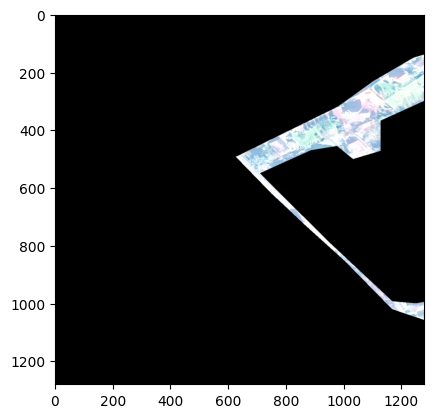

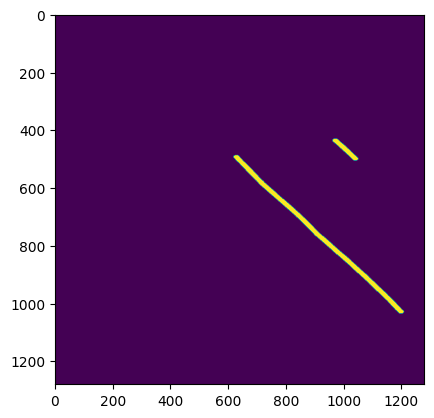

In [8]:
X, y = test_gen[0]
plt.figure(0)
plt.imshow(X[0])
plt.figure(1)
plt.imshow(y[0])

In [9]:
X.shape

(1, 1280, 1280, 3)

In [10]:
def plot_training_history(history):
    """
    Plots model training history
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()

In [11]:
def train_road_seg():
    train_gen , test_gen = get_train_test_generators(roads_data_path, batch_size = 8)
    lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
    mode_autosave = ModelCheckpoint(f"{weights_path}/unet_roads.h5", monitor='val_iou_score',
                                    mode = 'max', save_best_only=True,
                                    verbose=1, period = 5)

    early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'min', start_from_epoch = 20)


    callbacks = [mode_autosave, lr_reducer, early_stopping]
    model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
    model.compile(optimizer = Adam(),
                        loss=bce_dice_loss, metrics=[iou_score])

    history = model.fit_generator(train_gen, shuffle =True,
                    epochs=60, workers=4, use_multiprocessing=True,
                    validation_data = test_gen,
                    verbose = 1, callbacks=callbacks)
    #plotting history
    plot_training_history(history)
    return model, history

In [12]:
def train_building_seg():
    train_gen , test_gen = get_train_test_generators(buildings_data_path, batch_size = 12)
    lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
    mode_autosave = ModelCheckpoint(f"{weights_path}/unet_buildings.h5", monitor='val_iou_score',
                                    mode = 'max', save_best_only=True,
                                    verbose=1, period = 5)

    # early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'min', start_from_epoch = 20)


    callbacks = [mode_autosave, lr_reducer]
    model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)
    model.compile(optimizer = Adam(),
                        loss=bce_dice_loss, metrics=[iou_score])

    history = model.fit_generator(train_gen, shuffle =True,
                    epochs=60, workers=4, use_multiprocessing=True,
                    validation_data = test_gen,
                    verbose = 1, callbacks=callbacks)
    #plotting history
    plot_training_history(history)
    return model, history

## Road Segmentation

Train fnames = 205, test_fnames = 51
For train, number of images = 205, number of masks = 205
All img-mask pairs exist
For test, number of images = 51, number of masks = 51
All img-mask pairs exist
16804768/16804768 [==============================] - 0s 0us/step


<ipython-input-11-bd586ee57836>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, shuffle =True,
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Epoch 1/60
26/26 [==============================] - 204s 5s/step - loss: 1.1035 - iou_score: 0.0722 - val_loss: 1.7200 - val_iou_score: 0.0806 - lr: 0.0010
Epoch 2/60
26/26 [==============================] - 124s 4s/step - loss: 0.9302 - iou_score: 0.1215 - val_loss: 1.4981 - val_iou_score: 0.0819 - lr: 0.0010
Epoch 3/60
26/26 [==============================] - 157s 6s/step - loss: 0.8505 - iou_score: 0.1792 - val_loss: 3.3860 - val_iou_score: 0.0920 - lr: 0.0010
Epoch 4/60
26/26 [==============================] - 125s 5s/step - loss: 0.7624 - iou_score: 0.2336 - val_loss: 1.3386 - val_iou_score: 0.1441 - lr: 0.0010
Epoch 5/60
26/26 [==============================] - ETA: 0s - loss: 0.7778 - iou_score: 0.2285
Epoch 5: val_iou_score improved from -inf to 0.14843, saving model to /content/drive/MyDrive/autotop_data/weights/unet_roads.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 170s 6s/step - loss: 0.7778 - iou_score: 0.2285 - val_loss: 1.7645 - val_iou_score: 0.1484 - lr: 0.0010
Epoch 6/60
26/26 [==============================] - 126s 5s/step - loss: 0.7855 - iou_score: 0.2207 - val_loss: 0.9443 - val_iou_score: 0.1855 - lr: 0.0010
Epoch 7/60
26/26 [==============================] - 132s 5s/step - loss: 0.7585 - iou_score: 0.2457 - val_loss: 1.0507 - val_iou_score: 0.1413 - lr: 0.0010
Epoch 8/60
26/26 [==============================] - 126s 5s/step - loss: 0.7858 - iou_score: 0.2371 - val_loss: 1.0131 - val_iou_score: 0.1633 - lr: 0.0010
Epoch 9/60
26/26 [==============================] - 157s 6s/step - loss: 0.7271 - iou_score: 0.2696 - val_loss: 0.8979 - val_iou_score: 0.1680 - lr: 0.0010
Epoch 10/60
26/26 [==============================] - ETA: 0s - loss: 0.7138 - iou_score: 0.2785
Epoch 10: val_iou_score improved from 0.14843 to 0.22831, saving model to /content/drive/MyDrive/autotop_data/weights/unet_roads.h5
26/

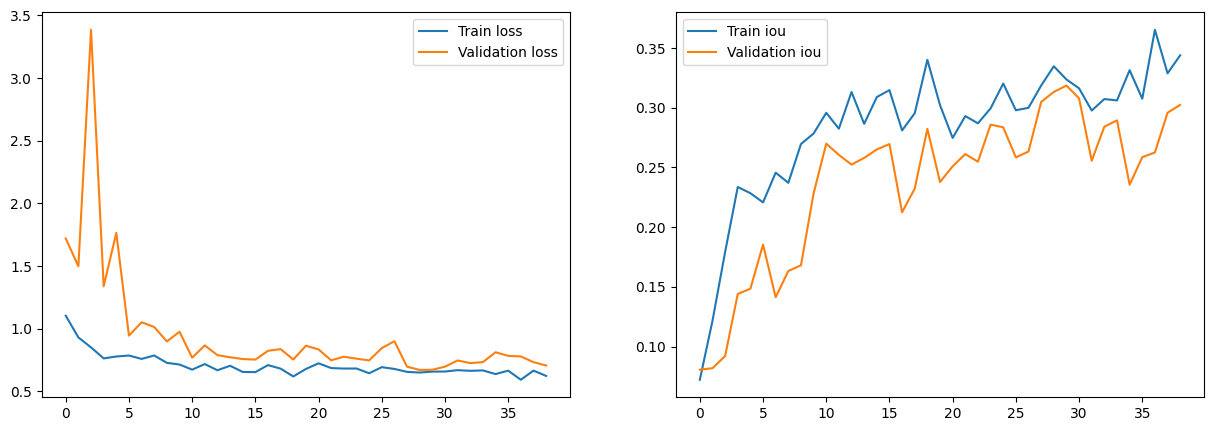

In [13]:
road_seg, road_history = train_road_seg()

## Building Segmentation

In [ ]:
building_seg, building_history = train_building_seg()

Train fnames = 918, test_fnames = 229
For train, number of images = 918, number of masks = 918
All img-mask pairs exist
For test, number of images = 229, number of masks = 229
All img-mask pairs exist
16804768/16804768 [==============================] - 0s 0us/step


<ipython-input-12-31ff4d50864b>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen, shuffle =True,
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Epoch 1/60
77/77 [==============================] - 214s 2s/step - loss: 0.8648 - iou_score: 0.2411 - val_loss: 4.9804 - val_iou_score: 0.1361 - lr: 0.0010
Epoch 2/60
77/77 [==============================] - 122s 2s/step - loss: 0.6046 - iou_score: 0.3812 - val_loss: 1.1534 - val_iou_score: 0.2068 - lr: 0.0010
Epoch 3/60
77/77 [==============================] - 122s 2s/step - loss: 0.5483 - iou_score: 0.4282 - val_loss: 0.9506 - val_iou_score: 0.2405 - lr: 0.0010
Epoch 4/60
77/77 [==============================] - 123s 2s/step - loss: 0.5300 - iou_score: 0.4419 - val_loss: 1.0868 - val_iou_score: 0.2100 - lr: 0.0010
Epoch 5/60
77/77 [==============================] - ETA: 0s - loss: 0.4881 - iou_score: 0.4790
Epoch 5: val_iou_score improved from -inf to 0.25716, saving model to /content/drive/MyDrive/autotop_data/weights/unet_buildings.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


77/77 [==============================] - 129s 2s/step - loss: 0.4881 - iou_score: 0.4790 - val_loss: 0.8159 - val_iou_score: 0.2572 - lr: 0.0010
Epoch 6/60
77/77 [==============================] - 122s 2s/step - loss: 0.5014 - iou_score: 0.4699 - val_loss: 0.8163 - val_iou_score: 0.2492 - lr: 0.0010
Epoch 7/60
77/77 [==============================] - 120s 2s/step - loss: 0.4712 - iou_score: 0.4921 - val_loss: 0.8041 - val_iou_score: 0.2682 - lr: 0.0010
Epoch 8/60
77/77 [==============================] - 122s 2s/step - loss: 0.4632 - iou_score: 0.5034 - val_loss: 0.9503 - val_iou_score: 0.2427 - lr: 0.0010
Epoch 9/60
77/77 [==============================] - 122s 2s/step - loss: 0.4536 - iou_score: 0.5056 - val_loss: 0.8878 - val_iou_score: 0.2052 - lr: 0.0010
Epoch 10/60
77/77 [==============================] - ETA: 0s - loss: 0.4672 - iou_score: 0.5007
Epoch 10: val_iou_score improved from 0.25716 to 0.28011, saving model to /content/drive/MyDrive/autotop_data/weights/unet_buildings.h5

In [13]:
unet_roads = tf.keras.models.load_model(f"{weights_path}/unet_roads.h5", compile=False)
unet_buildings = tf.keras.models.load_model(f"{weights_path}/unet_buildings.h5", compile=False)

In [14]:
r_train_gen , r_test_gen = get_train_test_generators(roads_data_path, batch_size = 8)
b_train_gen , b_test_gen = get_train_test_generators(buildings_data_path, batch_size = 12)

Train fnames = 205, test_fnames = 51
For train, number of images = 205, number of masks = 205
All img-mask pairs exist
For test, number of images = 51, number of masks = 51
All img-mask pairs exist
Train fnames = 918, test_fnames = 229
For train, number of images = 918, number of masks = 918
All img-mask pairs exist
For test, number of images = 229, number of masks = 229
All img-mask pairs exist


In [25]:
def evaluate_on_test(model, test_gen, num_plot = 5, seed = 0):
    # Evaluates model on test_gen
    # collect iou scores for plotting histogram, and randomly pick 5 test images to plot
    len_test = len(test_gen)
    rng = np.random.default_rng(seed)
    plot_list = rng.choice(len_test, size = num_plot, replace = False)
    print(f"Plotting {plot_list}")
    results_arr = np.zeros((len_test, 2))
    for i in range(len_test):
        X, y = test_gen[i]
        y_pred = model.predict(X)
        iou = iou_score(y, y_pred).numpy()
        coverage = np.mean(y)
        results_arr[i][0] = iou
        results_arr[i][1] = coverage
        print(f"{i+1}/{len_test}, res={results_arr[i]}")
        if(i in plot_list):
            plt.figure(i)
            plt.title(f"IoU = {iou:.3f}")
            plt.subplot(131)
            plt.imshow(X[0])

            plt.subplot(132)
            plt.imshow(y_pred[0], cmap='gray')

            plt.subplot(133)
            plt.imshow(y[0], cmap='gray')
    plt.figure()
    plt.hist(results_arr[:, 0])
    plt.xlabel("IoU Score")
    plt.ylabel("Number of test images")
    return results_arr

Plotting [30 25 13 15 39]
1/1 [==============================] - 10s 10s/step
1/51, res=[0.29762164 0.00915161]
1/1 [==============================] - 7s 7s/step
2/51, res=[0.40776336 0.06060547]
1/1 [==============================] - 10s 10s/step
3/51, res=[0.51166582 0.08581726]
1/1 [==============================] - 7s 7s/step
4/51, res=[0.04617582 0.01406921]
1/1 [==============================] - 8s 8s/step
5/51, res=[0.01815378 0.00738098]
1/1 [==============================] - 10s 10s/step
6/51, res=[0.00216848 0.00829956]
1/1 [==============================] - 7s 7s/step
7/51, res=[0.4714188  0.05370666]
1/1 [==============================] - 7s 7s/step
8/51, res=[0.12598933 0.00850403]
1/1 [==============================] - 9s 9s/step
9/51, res=[0.33204505 0.03807861]
1/1 [==============================] - 8s 8s/step
10/51, res=[0.39196053 0.027677  ]
1/1 [==============================] - 7s 7s/step
11/51, res=[0.39951336 0.05067993]
1/1 [==============================] - 9s 

<ipython-input-25-da4d798febc2>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


1/1 [==============================] - 8s 8s/step
15/51, res=[0.00392633 0.02064331]
1/1 [==============================] - 8s 8s/step
16/51, res=[0.08633237 0.02279968]
1/1 [==============================] - 10s 10s/step
17/51, res=[0.03292008 0.0180481 ]
1/1 [==============================] - 7s 7s/step
18/51, res=[0.35594791 0.06549621]
1/1 [==============================] - 8s 8s/step
19/51, res=[0.58537883 0.06066895]
1/1 [==============================] - 10s 10s/step
20/51, res=[0.07294739 0.01955139]
1/1 [==============================] - 7s 7s/step
21/51, res=[0.46278608 0.06148804]
1/1 [==============================] - 8s 8s/step
22/51, res=[0.45542559 0.06188232]
1/1 [==============================] - 10s 10s/step
23/51, res=[0.45654577 0.05890198]
1/1 [==============================] - 7s 7s/step
24/51, res=[0.55716354 0.07539184]
1/1 [==============================] - 7s 7s/step
25/51, res=[0.26423776 0.02526245]
1/1 [==============================] - 9s 9s/step
26/51, re

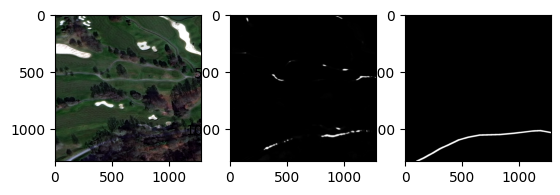

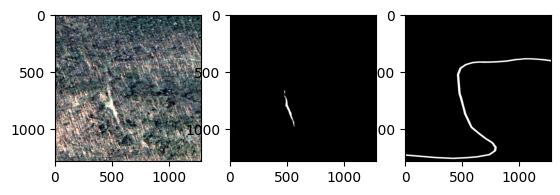

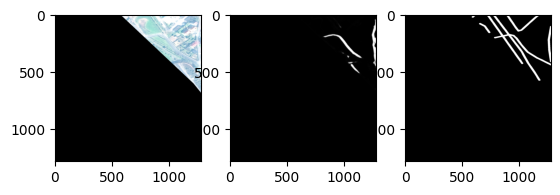

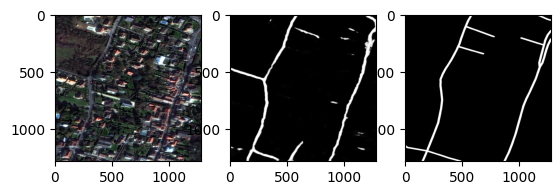

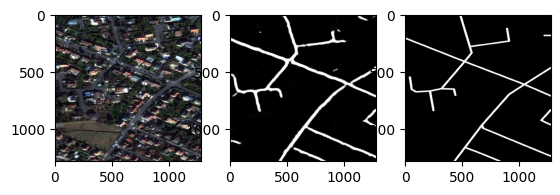

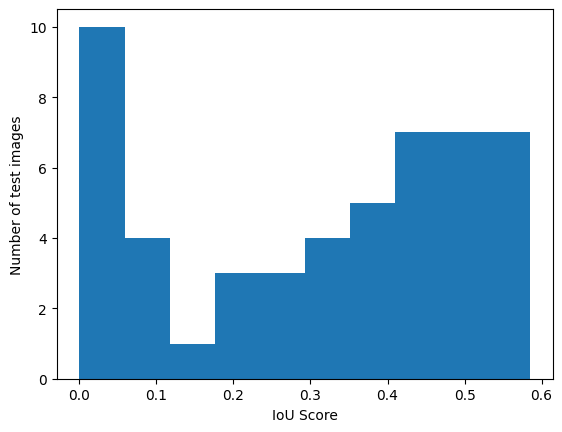

In [26]:
ret = evaluate_on_test(unet_roads, r_test_gen)

Plotting [143 116  61  70 191]
1/1 [==============================] - 3s 3s/step
1/229, res=[0.62577718 0.17953369]
1/1 [==============================] - 2s 2s/step
2/229, res=[0.67643589 0.13839844]
1/1 [==============================] - 2s 2s/step
3/229, res=[3.68108743e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
4/229, res=[0.31121302 0.03112305]
1/1 [==============================] - 1s 1s/step
5/229, res=[0.63650268 0.19302002]
1/1 [==============================] - 2s 2s/step
6/229, res=[0.66047674 0.18821777]
1/1 [==============================] - 3s 3s/step
7/229, res=[6.45988962e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
8/229, res=[0.67652506 0.19431153]
1/1 [==============================] - 2s 2s/step
9/229, res=[0.68665296 0.20485596]
1/1 [==============================] - 2s 2s/step
10/229, res=[4.34184614e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
11/229, res=[0.58881402 0.08579834]
1/1 [===

<ipython-input-25-da4d798febc2>:20: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(131)


1/1 [==============================] - 2s 2s/step
63/229, res=[0.61157864 0.09829102]
1/1 [==============================] - 2s 2s/step
64/229, res=[2.19966793e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
65/229, res=[0.60190886 0.15158692]
1/1 [==============================] - 2s 2s/step
66/229, res=[1.80658432e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
67/229, res=[6.15817953e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
68/229, res=[9.5316139e-08 0.0000000e+00]
1/1 [==============================] - 2s 2s/step
69/229, res=[6.27700729e-07 0.00000000e+00]
1/1 [==============================] - 2s 2s/step
70/229, res=[0.41871884 0.02908691]
1/1 [==============================] - 2s 2s/step
71/229, res=[0.74155629 0.19462891]
1/1 [==============================] - 2s 2s/step
72/229, res=[3.96092261e-08 0.00000000e+00]
1/1 [==============================] - 3s 3s/step
73/229, res=[0.00685283 0.02441894]
1/1 [===

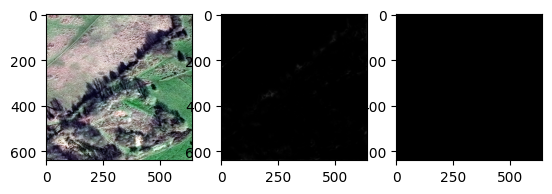

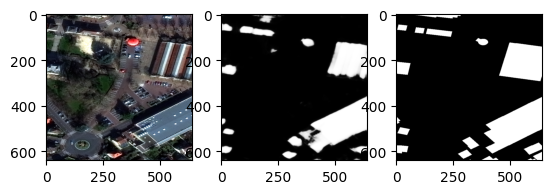

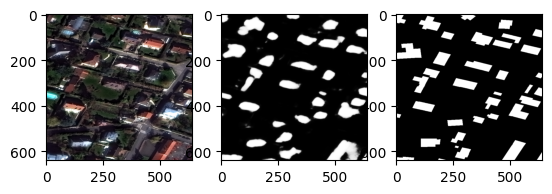

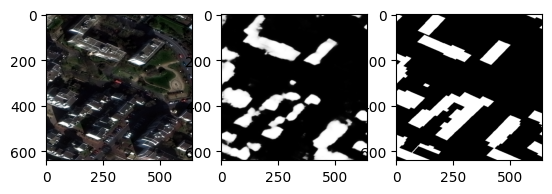

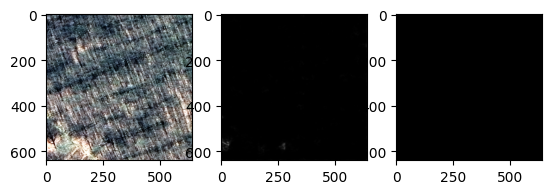

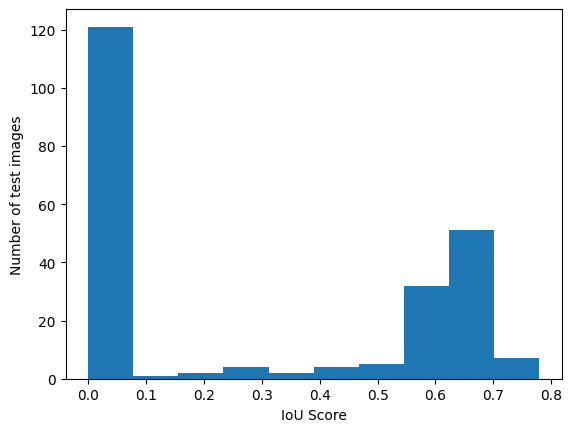

In [27]:
ret_b = evaluate_on_test(unet_buildings, b_test_gen)

## Observations


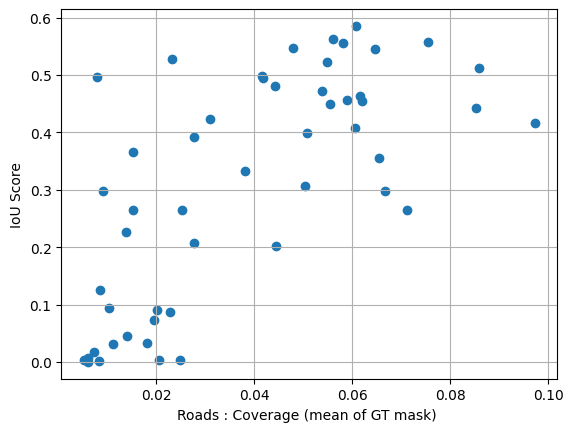

In [28]:
plt.scatter(ret[:,1], ret[:, 0])
plt.xlabel("Roads : Coverage (mean of GT mask) ")
plt.ylabel("IoU Score")
plt.grid(True)

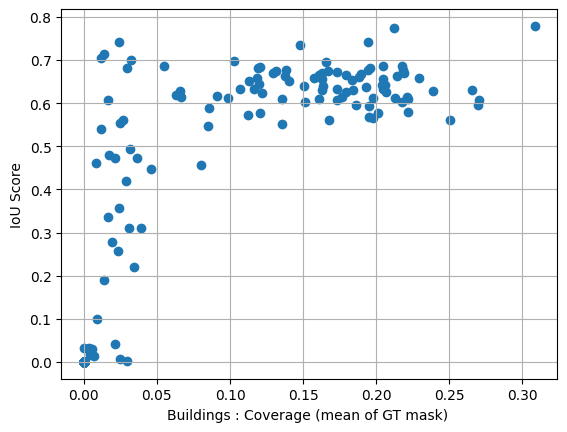

In [29]:
plt.scatter(ret_b[:,1], ret_b[:, 0])
plt.xlabel("Buildings : Coverage (mean of GT mask) ")
plt.ylabel("IoU Score")
plt.grid(True)

Mean IoU of all test images = 0.307
Mean IoU of selected test images with >= 2% coverage = 0.388


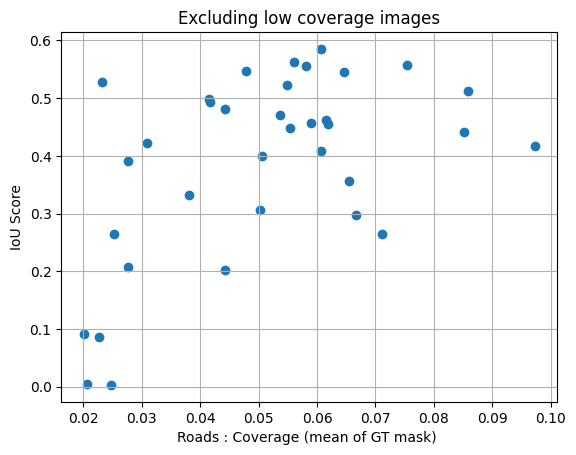

In [37]:
# Excluding very low coverage (nearly blank images) for stats comparison
ret_r_sel = ret[ret[:, 1]>= 0.02]
print(f"Mean IoU of all test images = {ret[:, 0].mean():.3f}")
print(f"Mean IoU of selected test images with >= 2% coverage = {ret_r_sel[:, 0].mean():.3f}")
plt.title("Excluding low coverage images")
plt.scatter(ret_r_sel[:,1], ret_r_sel[:, 0])
plt.xlabel("Roads : Coverage (mean of GT mask) ")
plt.ylabel("IoU Score")
plt.grid(True)

Mean IoU of all test images = 0.282
Mean IoU of selected test images with >= 2% coverage = 0.593


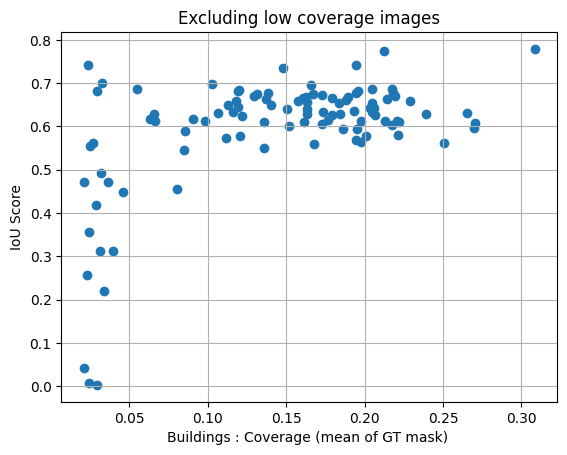

In [38]:
# Excluding very low coverage (nearly blank images) for stats comparison
ret_b_sel = ret_b[ret_b[:, 1]>= 0.02]
print(f"Mean IoU of all test images = {ret_b[:, 0].mean():.3f}")
print(f"Mean IoU of selected test images with >= 2% coverage = {ret_b_sel[:, 0].mean():.3f}")

plt.title("Excluding low coverage images")
plt.scatter(ret_b_sel[:,1], ret_b_sel[:, 0])
plt.xlabel("Buildings : Coverage (mean of GT mask) ")
plt.ylabel("IoU Score")
plt.grid(True)

## Rough summary
Due to the nature of the road masks being sparse in coverage (even a road-dense neighbourhood has 6% to 10% of the area being classified as 'road'), misclassification of pixels is higher and even a well predicted road network image (which will get thresholded, skeletonized and converted into a graph which is nearly equal to the ground truth network) will have an IoU score of 0.4 - 0.6

Building masks are denser, and can have coverage of 20% to 30% in a mask image. It is seen that the IoU score increases with a denser building mask, which is encouraging. A building-dense region like a city center will have an IoU score of 0.6 - 0.75